<a href="https://colab.research.google.com/github/Sneha-Mahapatra/Heart-Disease-Prediction/blob/main/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Heart Disease Prediction**

In [2]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

###**EDA: Descriptive Statistics**
We will start with exploring our dataset. As per the source, each patient has the following information collected about them:

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [8]:
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv


In [9]:
#load dataset
df = pd.read_csv("heart.csv")

In [10]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [11]:
print(df.dtypes)
df.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

In [12]:
df.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

From the table above, we can observe that:

- The average age of patients is ~53 years.
- The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- RestingBP and Cholesterol have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

In [13]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in this dataset

###**EDA: Categorical Data**
We identified that most of the categorical columns are all of dtype object.

In [14]:
df.describe(include=['object'])

Sex ChestPainType RestingECG ExerciseAngina ST_Slope
count   918           918        918            918      918
unique    2             4          3              2        3
top       M           ASY     Normal              N     Flat
freq    725           496        552            547      460

In [15]:
df["FastingBS"].unique(), df["HeartDisease"].unique()

(array([0, 1]), array([0, 1]))

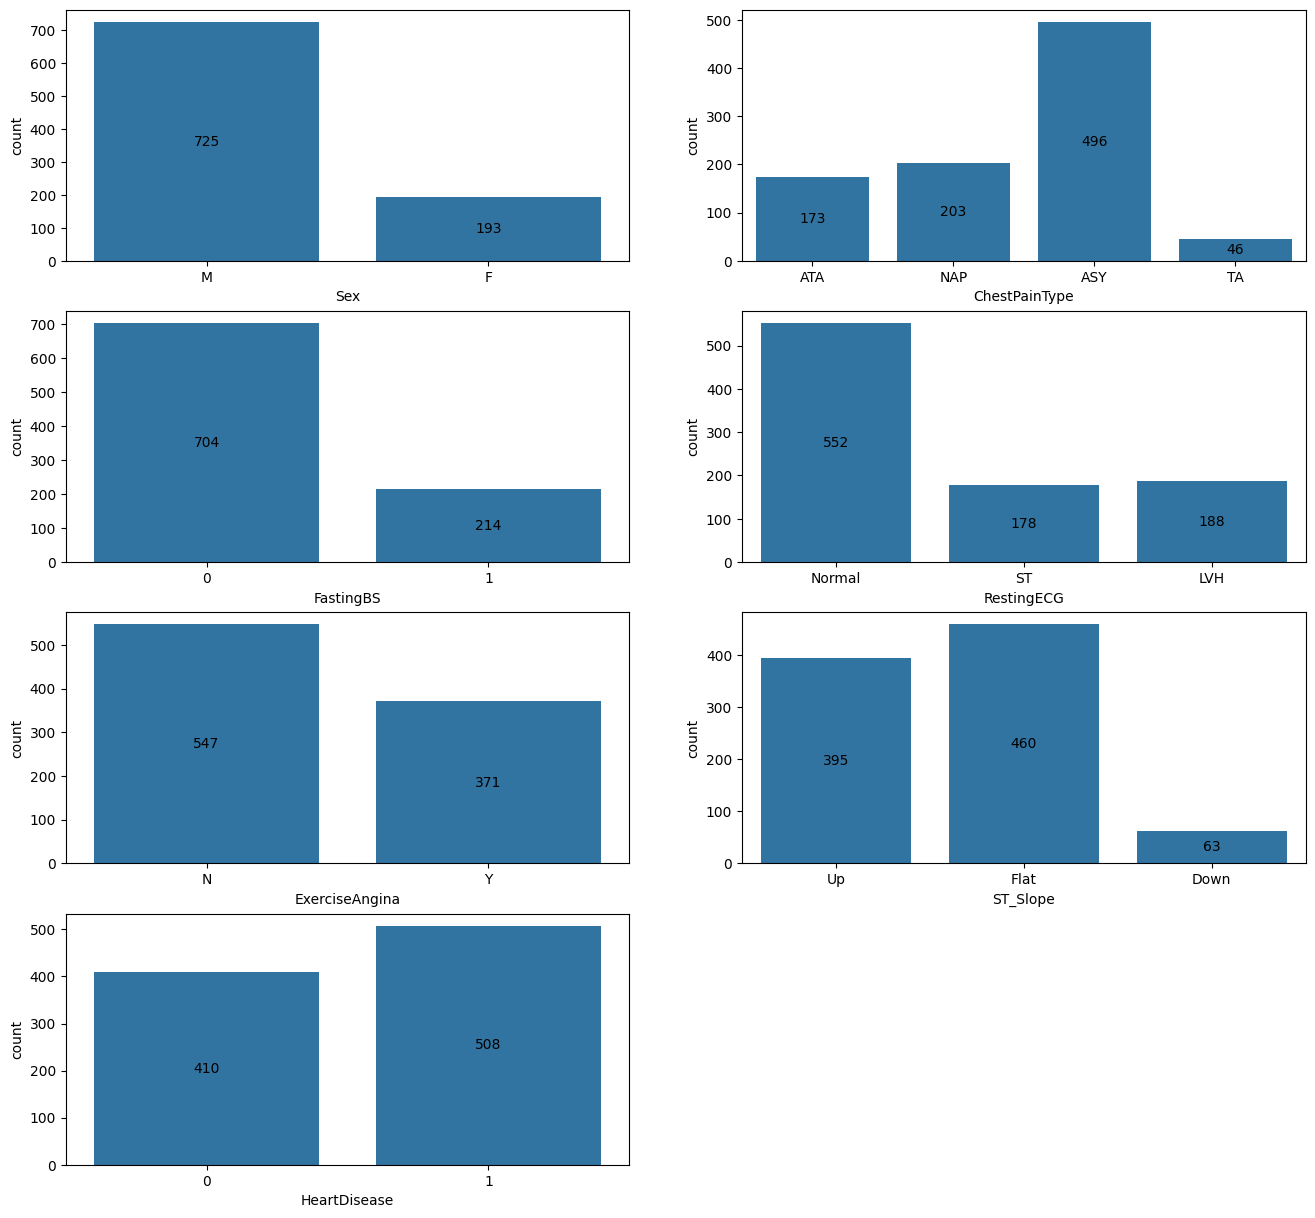

In [16]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- The dataset is highly skewed towards male patients. There are 725 male patients and 193 female patients. This could potentially induce a bias in our model.
- 496 patients had ASY (asymptotic) chest pain type.
- 552 patients had a normal restin ECG.
- 704 patients had blood sugar lower than 120 mg/dl

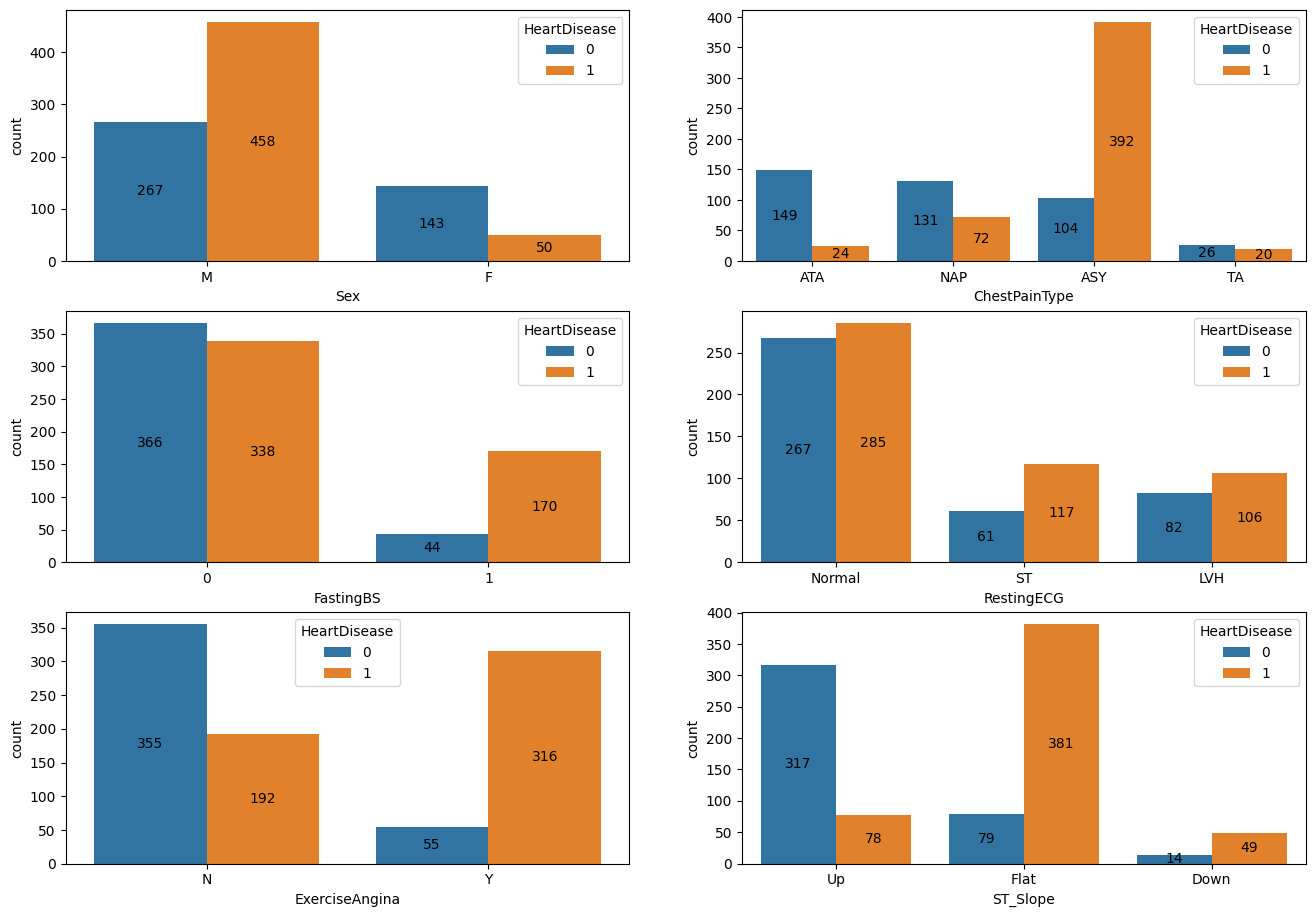

In [17]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- We can further notice how skewed the dataset is towards male patients. Only 50 female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
- A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.

###**Data Cleaning**

In [18]:
df[df["RestingBP"] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N      1.5     Flat             1

In [19]:
df[df["Cholesterol"] == 0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
293   65   M           ASY        115            0          0     Normal   
294   32   M            TA         95            0          1     Normal   
295   61   M           ASY        105            0          1     Normal   
296   50   M           ASY        145            0          1     Normal   
297   57   M           ASY        110            0          1         ST   
..   ...  ..           ...        ...          ...        ...        ...   
514   43   M           ASY        122            0          0     Normal   
515   63   M           NAP        130            0          1         ST   
518   48   M           NAP        102            0          1         ST   
535   56   M           ASY        130            0          0        LVH   
536   62   M           NAP        133            0          1         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
293     93              Y      0.0     Flat             1  
294    127              N      0.7       Up             1  
295    110              Y      1.5       Up             1  
296    139              Y      0.7     Flat             1  
297    131              Y      1.4       Up             1  
..     ...            ...      ...      ...           ...  
514    120              N      0.5       Up             1  
515    160              N      3.0     Flat             0  
518    110              Y      1.0     Down             1  
535    122              Y      1.0     Flat             1  
536    119              Y      1.2     Flat             1  

[172 rows x 12 columns]

In [20]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [21]:
df_clean[["Cholesterol", "RestingBP"]].describe()

Cholesterol   RestingBP
count   917.000000  917.000000
mean    239.700109  132.540894
std      54.352727   17.999749
min      85.000000   80.000000
25%     214.000000  120.000000
50%     225.000000  130.000000
75%     267.000000  140.000000
max     603.000000  200.000000

The minimum values for both have changed! There are no more zero values in either of those.

###**Feature Selection**
Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- Age
- Sex
- ChestPainType
- Cholesterol
- FastingBS

We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In [22]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0   True               True              False             False   
1  False              False               True             False   
2   True               True              False             False   
3  False              False              False             False   
4   True              False               True             False   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0               True          False             False          False   
1               True          False             False           True   
2              False           True             False          False   
3               True          False              True           True   
4               True          False             False          False   

   ST_Slope_Up  
0         True  
1        False  
2         True  
3        False  
4         True

<Axes: >

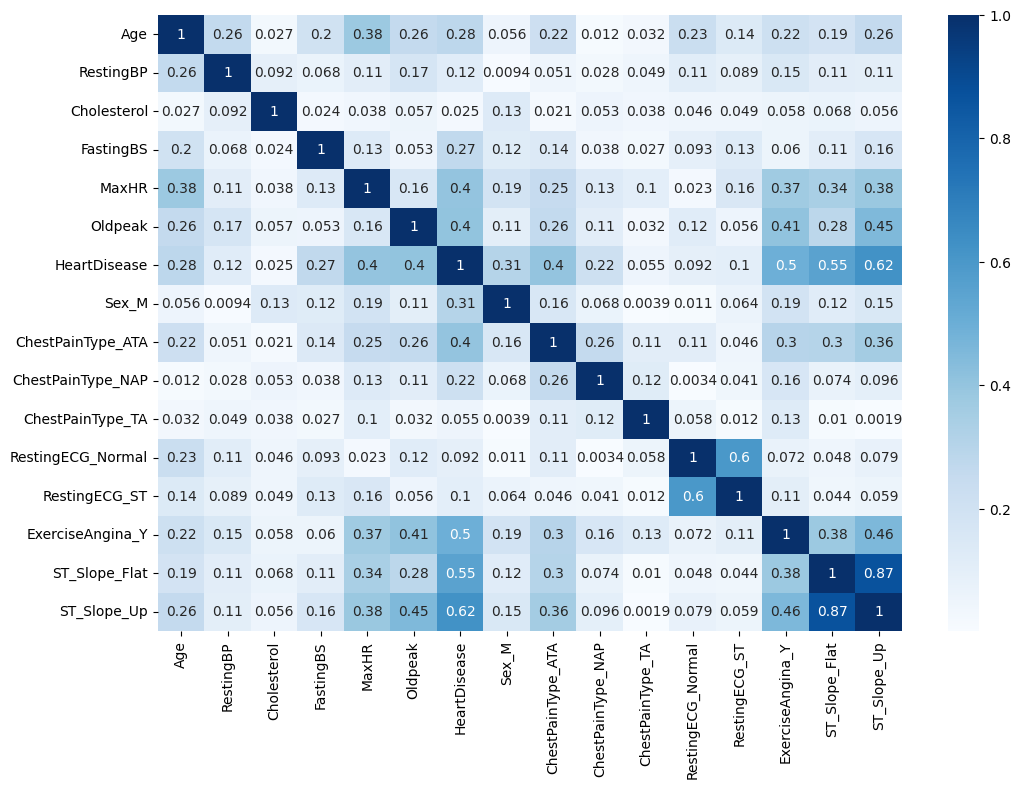

In [23]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

<Axes: >

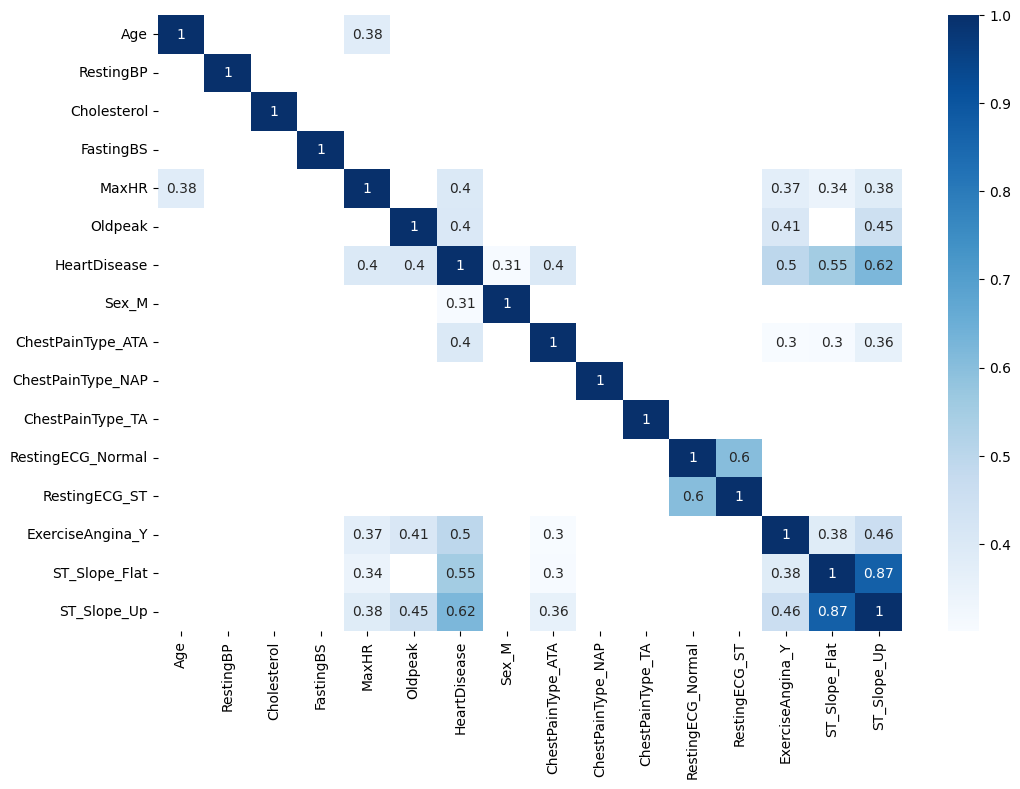

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to HeartDisease:

- Oldpeak
- MaxHR
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

The correlation coefficient threshold was chosen arbitrarily. Surprisingly, Cholesterol is not strongly correlated to HeartDisease. We can consider ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:
- Oldpeak
- Sex_M
- It has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account.
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

###**Building a Classifier with One Feature**

In [25]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

In [26]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 76.81%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 44.93%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 84.06%


###**Building a Classifier with Multiple Features**

In [27]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [28]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 86.23


###**Hyperparameter Optimization**

In [29]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

In [30]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [31]:
knn_grid.best_score_*100, knn_grid.best_params_

(np.float64(83.56327543424318), {'metric': 'minkowski', 'n_neighbors': 19})

###**Model Evaluation on Test Set**

In [32]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 86.23


In [33]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64
